# Tutorial on Parallelized Calculations

This tutorial demonstrates how to use QuantumDNA to calculate a range of observables that characterize the electronic and dynamic properties of DNA systems. By leveraging efficient computation and parallelization capabilities, you can analyze large datasets and complex systems.

Observables Covered:

* **Exciton Lifetime (femtoseconds)**
Estimate the lifetime of excitons, which play a critical role in energy transport and recombination processes within DNA.

* **Average Charge Separation (Å)**
Compute the spatial separation between electrons and holes, providing insights into charge transfer efficiency and molecular stability.

* **Dipole Moment (Debye)**
Analyze the molecular dipole moment, an important property that governs interactions with external fields and other molecules.

* **Average Exciton Population on Upper and Lower DNA Strands**
Quantify the distribution of exciton populations between the two DNA strands, shedding light on strand-specific dynamics and energy transport.

Example Application:
As an illustrative example, the calculations are applied to all 64 possible DNA trimer/triplet sequences, allowing for a systematic investigation of how sequence composition influences these properties. This analysis showcases the versatility of the package for exploring sequence-dependent electronic characteristics.

By the end of this notebook, you will have an understanding of how to perform these calculations and utilize QuantumDNA's parallelization features to efficiently analyze large-scale systems.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/dehe1011/QuantumDNA-notebooks/blob/main/tutorials/5_Evaluation.ipynb)

In [11]:
%load_ext autoreload
%autoreload 2

# Save flag: Set to True to enable saving results (currently unused in this script)
save = False

# Verbose flag: Set to True to enable detailed logging
verbose = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Installation of QuantumDNA
# --------------------------

from importlib.util import find_spec

qDNA_installed = find_spec('qDNA') is not None

if not qDNA_installed:
    %pip install qDNA
    print("Successfully installed the 'qDNA' package.")
else:
    print("Package 'qDNA' is already installed.")

if verbose:
    %pip show qDNA 

from qDNA import *

# ------------------------
# Directory Setup
# ------------------------

import os

# Use the current working directory as the root
ROOT_DIR = os.getcwd()

# Define directory to save figures
SAVE_DIR = os.path.join(DATA_DIR, "my_figures")
os.makedirs(SAVE_DIR, exist_ok=True)

if verbose:
    print(f"Save directory: '{SAVE_DIR}' is ready.")

Package 'qDNA' is already installed.


## Parallelized Calculations for DNA Trimers

In [17]:
from itertools import product

bases = ['A', 'T', 'G', 'C']
triplets = [''.join(p) for p in product(bases, repeat=3)]
triplets = [get_tb_sites(triplet) for triplet in triplets]

eva_list = [Evaluation(triplet, relax_rate=3.) for triplet in triplets]
eva_parallel = EvaluationParallel(eva_list, observables=["lifetime", "charge_separation", "dipole_moment", "exciton_transfer"])
result_dict = eva_parallel.calc_results(save=False)

Calculating observables: ['lifetime', 'charge_separation', 'dipole_moment', 'exciton_transfer']: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:21<00:00,  2.98it/s]


## DNA Trimer Analysis

In [46]:
vals = list(result_dict.values())

triplets = [''.join(p) for p in product(bases, repeat=3)]
lifetime_dict = dict(zip(triplets, [val[0] for val in vals[:-1]] ))
dipole_dict = dict(zip(triplets, [val[1] for val in vals[:-1]] ))
dipole_moment_dict = dict(zip(triplets, [val[2] for val in vals[:-1]] ))
exciton_transfer_dict = dict(zip(triplets, [val[3] for val in vals[:-1]] ))

# consider only the lower strand average exciton population
exciton_transfer_lower_dict = {key: value['lower_strand_pop']['exciton'] for key, value in exciton_transfer_dict.items()}

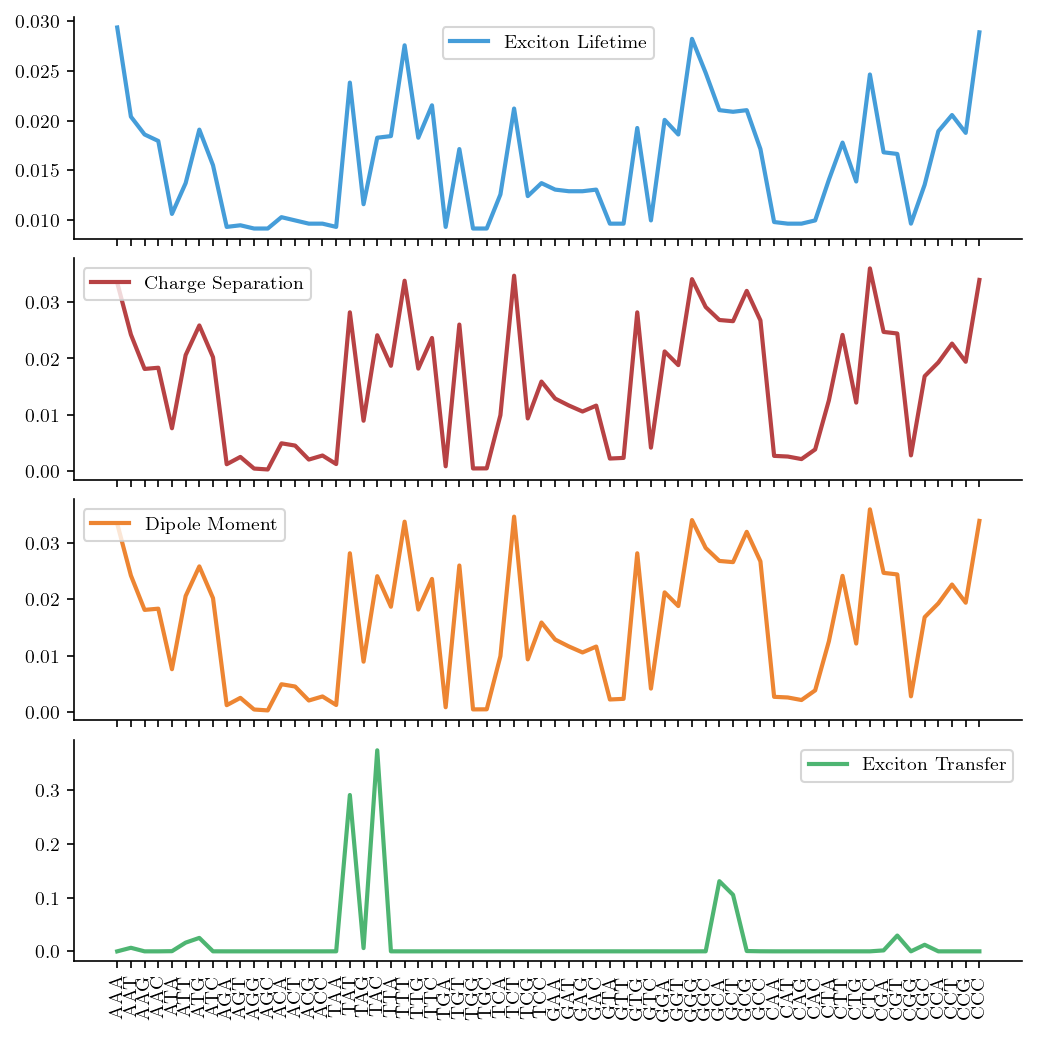

In [47]:
import seaborn as sns

def normalize_dict_values(data):
    total = sum(data.values())
    return {key: value / total for key, value in data.items()}

dicts = [normalize_dict_values(dictionary) for dictionary in [lifetime_dict, dipole_dict, dipole_moment_dict, exciton_transfer_lower_dict]]
labels = ['Exciton Lifetime', 'Charge Separation', 'Dipole Moment', 'Exciton Transfer']
colors = sns.color_palette()[:4]

fig, ax = plt.subplots(4, 1, figsize=(6.8,6.8), sharex=True)
for i in range(4):
    dictionary = dicts[i]
    ax[i].plot(range(64), dictionary.values(), label=labels[i], color=colors[i])
    ax[i].legend()
    
dna_seqs = list(lifetime_dict.keys())
ax[-1].set_xticks(range(64), labels=triplets, rotation=90)

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))

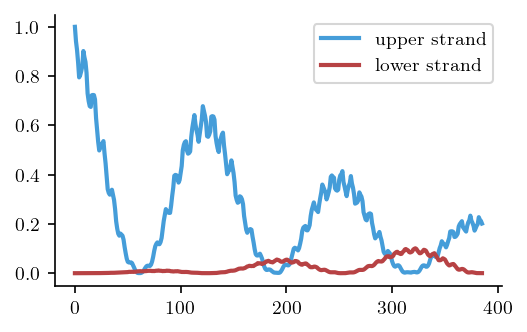

In [57]:
# The analysis above shows there are some intersting triplet sequences (TAT, TAC, GCA, GCT). Let's have a closer look.

tb_sites = get_tb_sites('GCT')
eva = Evaluation(tb_sites, particles=['exciton'], relax_rate=3.)

exciton_transfer = eva.calc_exciton_transfer(average=False)
pop_upper_strand, pop_lower_strand = exciton_transfer['upper_strand_pop'], exciton_transfer['lower_strand_pop']

fig, ax = plt.subplots()
ax.plot(pop_upper_strand['exciton'], label='upper strand')
ax.plot(pop_lower_strand['exciton'], label='lower strand')
ax.legend()

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))

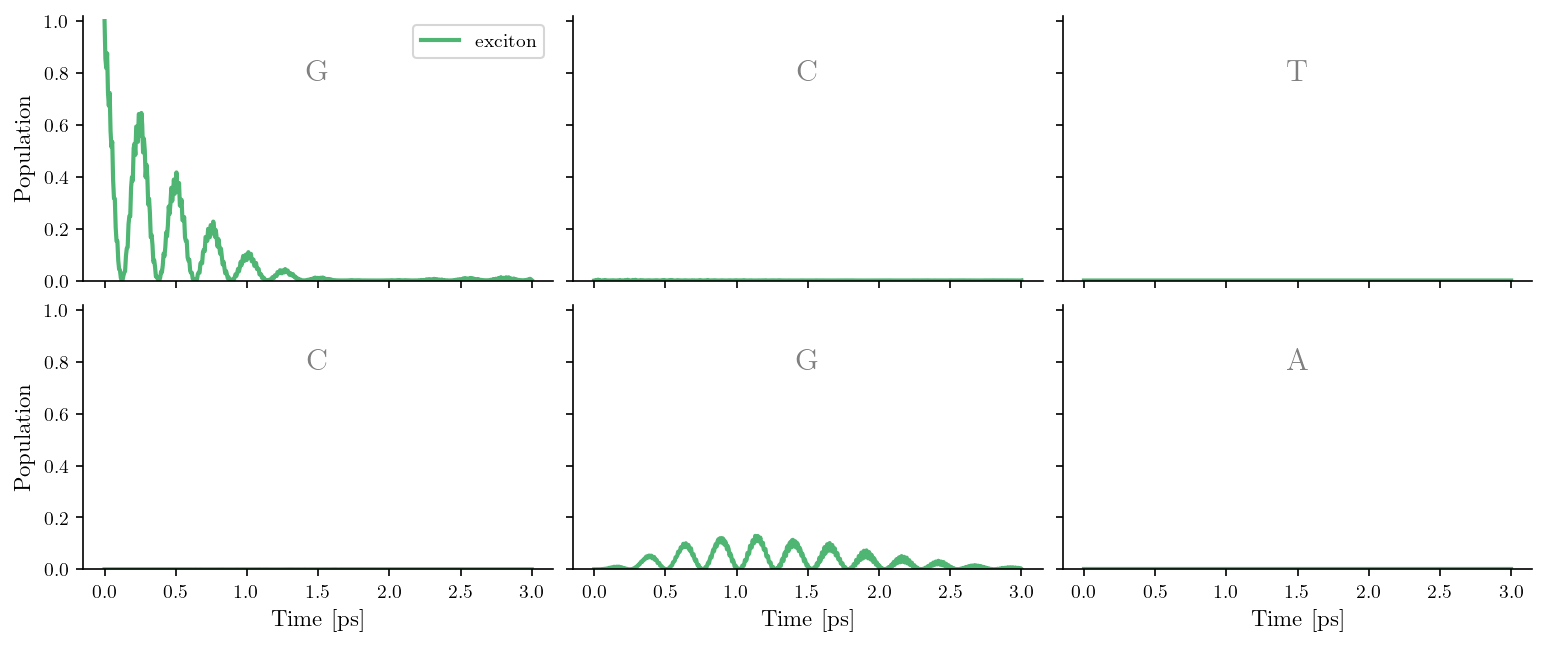

In [59]:
# we observe how the exciton gets transferred to the lower strand

tb_sites = get_tb_sites('GCT')
vis = Visualization(tb_sites, particles=['exciton'], relax_rate=3.)
fig, ax = vis.plot_pops()

if save:
    fig_filename = input("Filename for Saving: ")
    plt.savefig(os.path.join(SAVE_DIR, fig_filename + '.pdf'))